# Data Management Project: Bitcoin sentiment analysis

### Data sources:
- Bitcoin Volume: API endpoint -> https://api.binance.com/api/v3/klines
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [ ]:
!pip install python-dotenv

In [ ]:
!pip install kafka-python pymongo

In [ ]:
!pip install tqdm

In [1]:
import requests
import json
from datetime import datetime, date, timedelta
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pymongo import MongoClient

load_dotenv()

True

### BitCoin:

In [14]:
import yfinance as yf

# yfinance aggira i blocchi perché simula un browser che visita il sito
# Non ha limiti "hard" sugli anni passati
btc = yf.download(["BTC-USD","ETH-USD","^GSPC"], start="2018-01-01", end="2025-12-12")
df = btc

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\1538713557.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download(["BTC-USD","ETH-USD","^GSPC"], start="2018-01-01", end="2025-12-12")
[*********************100%***********************]  3 of 3 completed


In [18]:
df_stacked = df.stack(level=1, future_stack=True)
# Resettiamo l'indice per far diventare 'Date' e 'Ticker' delle colonne normali
df_final = df_stacked.reset_index()

# Rinominiamo le colonne per averle minuscole e pulite nel DB
# (es. 'Date' -> 'date', 'Ticker' -> 'ticker', 'Adj Close' -> 'adj_close')
df_final.columns = [c.lower().replace(' ', '_') for c in df_final.columns]

# Convertiamo la data in formato datetime nativo (se non lo è già)
df_final['date'] = pd.to_datetime(df_final['date'])

# --- 3. PULIZIA EXTRA ---
# MongoDB non accetta 'NaN' (Not a Number), che capita se un giorno un mercato è chiuso
# Sostituiamo NaN con None (che diventa null in Mongo) o 0
df_final = df_final.where(pd.notnull(df_final), None)

# Convertiamo il DataFrame in una lista di dizionari (records)
records = df_final.to_dict(orient='records')

print(f"Pronti per inserire {len(records)} record.")
# Esempio di come appare un record ora:
# {'date': datetime(...), 'ticker': 'BTC-USD', 'close': 13000.5, ...}

# --- 4. INSERIMENTO IN MONGODB ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Crypto']

try:
    if records:
        # Opzionale: pulire la collezione prima di inserire per evitare duplicati massivi
        # collection.delete_many({}) 
        
        result = collection.insert_many(records)
        print(f"✅ Successo! Inseriti {len(result.inserted_ids)} documenti in 'CryptoPrices'.")
    else:
        print("⚠️ Nessun dato da inserire.")

except Exception as e:
    print(f"❌ Errore durante l'inserimento: {e}")

# --- VERIFICA ---
print("\nVerifica ultimo inserimento per BTC:")
latest = collection.find_one({"ticker": "BTC-USD"}, sort=[("date", -1)])
print(latest)

Pronti per inserire 8706 record.
✅ Successo! Inseriti 8706 documenti in 'CryptoPrices'.

Verifica ultimo inserimento per BTC:
{'_id': ObjectId('693e7d760d29c3d5287a862c'), 'date': datetime.datetime(2025, 12, 11, 0, 0), 'ticker': 'BTC-USD', 'close': 92511.3359375, 'high': 93554.265625, 'low': 89335.296875, 'open': 92011.3046875, 'volume': 64532834621.0}


In [4]:
df = pd.DataFrame(btc) # Convert into DataFrame
print(df.columns)
df.head()

MultiIndex([( 'Close', 'BTC-USD'),
            ( 'Close', 'ETH-USD'),
            ( 'Close',   '^GSPC'),
            (  'High', 'BTC-USD'),
            (  'High', 'ETH-USD'),
            (  'High',   '^GSPC'),
            (   'Low', 'BTC-USD'),
            (   'Low', 'ETH-USD'),
            (   'Low',   '^GSPC'),
            (  'Open', 'BTC-USD'),
            (  'Open', 'ETH-USD'),
            (  'Open',   '^GSPC'),
            ('Volume', 'BTC-USD'),
            ('Volume', 'ETH-USD'),
            ('Volume',   '^GSPC')],
           names=['Price', 'Ticker'])


Price              Close                                   High               \
Ticker           BTC-USD     ETH-USD        ^GSPC       BTC-USD      ETH-USD   
Date                                                                           
2018-01-01  13657.200195  772.640991          NaN  14112.200195   782.530029   
2018-01-02  14982.099609  884.443970  2695.810059  15444.599609   914.830017   
2018-01-03  15201.000000  962.719971  2713.060059  15572.799805   974.471008   
2018-01-04  15599.200195  980.921997  2723.989990  15739.700195  1045.079956   
2018-01-05  17429.500000  997.719971  2743.149902  17705.199219  1075.390015   

Price                             Low                                   Open  \
Ticker            ^GSPC       BTC-USD     ETH-USD        ^GSPC       BTC-USD   
Date                                                                           
2018-01-01          NaN  13154.700195  742.004028          NaN  14112.200195   
2018-01-02  2695.889893  13163.599609  772.346008  2682.360107  13625.000000   
2018-01-03  2714.370117  14844.500000  868.450989  2697.770020  14978.200195   
2018-01-04  2729.290039  14522.200195  946.085999  2719.070068  15270.700195   
2018-01-05  2743.449951  15202.799805  956.325012  2727.919922  15477.200195   

Price                                     Volume                            
Ticker         ETH-USD        ^GSPC      BTC-USD     ETH-USD         ^GSPC  
Date                                                                        
2018-01-01  755.757019          NaN  10291200000  2595760128           NaN  
2018-01-02  772.346008  2683.729980  16846600192  5783349760  3.397430e+09  
2018-01-03  886.000000  2697.850098  16871900160  5093159936  3.544030e+09  
2018-01-04  961.713013  2719.310059  21783199744  6502859776  3.697340e+09  
2018-01-05  975.750000  2731.330078  23840899072  6683149824  3.239280e+09

In [5]:
df.isna().sum() # There is no Missing Values

Price   Ticker 
Close   BTC-USD      0
        ETH-USD      0
        ^GSPC      904
High    BTC-USD      0
        ETH-USD      0
        ^GSPC      904
Low     BTC-USD      0
        ETH-USD      0
        ^GSPC      904
Open    BTC-USD      0
        ETH-USD      0
        ^GSPC      904
Volume  BTC-USD      0
        ETH-USD      0
        ^GSPC      904
dtype: int64

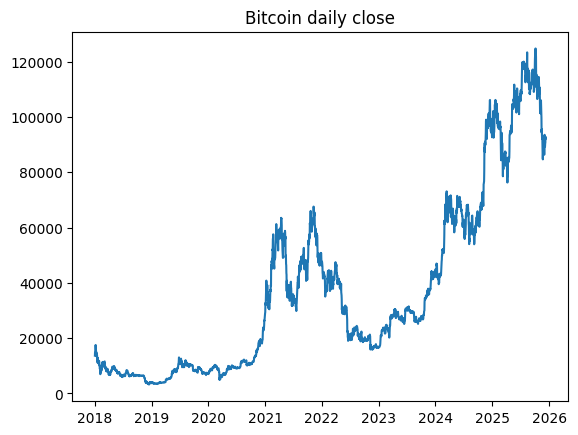

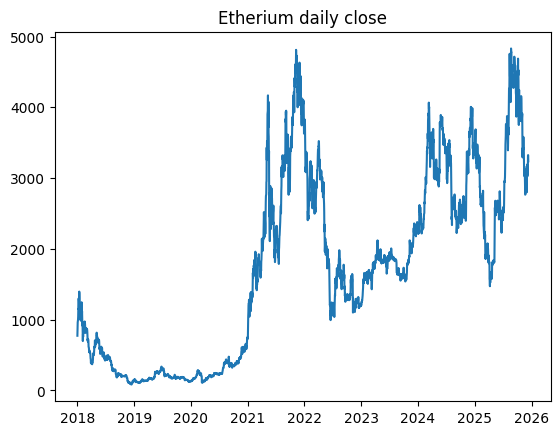

In [6]:
plt.figure()
plt.plot(df.index,df['Close']['BTC-USD'])
plt.title("Bitcoin daily close")
plt.show()
plt.figure()
plt.plot(df.index,df['Close']['ETH-USD'])
plt.title("Etherium daily close")
plt.show()

### NyTimes article:

1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


In [ ]:
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

# Imposta il periodo storico
start_date = date(2022, 10, 1)
end_date = date(2025, 12, 12)
current_date = start_date

DAILY_LIMIT = 490
calls_made = 0

key = os.getenv("NY_KEY2")
queries = ["Bitcoin", "Crypto", "Ethereum"]

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    # Formatta le date per l'API NYT (YYYYMMDD)
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"\n--- Analisi periodo: {begin_str} - {end_str} ---")
    
    # MODIFICA 1: Iteriamo prima per Query, poi per Pagine.
    # Questo ci permette di interrompere la paginazione per una query specifica appena finiscono i dati.
    for q in queries:
        print(f"Scaricando articoli per: {q}...")
        
        for page in range(100): # Massimo 100 pagine
            if calls_made >= DAILY_LIMIT:
                print(f"RAGGIUNTO IL LIMITE GIORNALIERO ({calls_made}). Mi fermo.")
                print(f"Ultimo periodo elaborato: {begin_str} - {end_str}, Query: {q}, Pagina: {page}")
                exit()
            try:
                # MODIFICA 2: Corretto q={q} nell'URL (prima era fisso su Bitcoin)
                url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                
                response = requests.get(url)
                response.raise_for_status() # Solleva errore se status != 200

                data = response.json()
                articles = data.get('response', {}).get('docs', [])

                # MODIFICA 3: Se non ci sono articoli, interrompiamo il ciclo delle pagine per QUESTA query
                if not articles:
                    print(f"  -> Nessun altro articolo per '{q}' a pagina {page}. Passo alla prossima query.")
                    break 

                # Invio messaggi a Kafka
                for article in articles:
                    clean_doc = {
                        'remote_id': article.get('_id'),
                        'web_url': article.get('web_url'),
                        'pub_date': article.get('pub_date'),
                        'abstract': article.get('abstract'),
                        'lead_paragraph': article.get('lead_paragraph'),
                        'title': article.get('headline', {}).get('main'),
                        'word_count': article.get('word_count'),
                        'source_query': q
                    }
                    
                    producer.send(q, clean_doc) # Usa 'q' come nome del topic (o usa un topic unico)
            
                producer.flush()
                print(f"  -> Inviati {len(articles)} articoli per '{q}' (Pagina {page})")
                
                # Rispetta il rate limit (15 secondi sono prudenziali e sicuri)
                time.sleep(15)
                calls_made += 1

            except Exception as e:
                print(f"  -> Errore con '{q}' a pagina {page}: {e}")
                # Opzionale: se l'errore è grave (es. 429 Too Many Requests), potresti voler fare un break anche qui
                # break 
                time.sleep(15) # Attesa anche in caso di errore per sicurezza
                continue

    # Passa al mese successivo solo dopo aver finito tutte le query per il mese corrente
    current_date = next_month

In [ ]:
# ---------------------------------------------------------
# CONFIGURAZIONE UTENTE
# ---------------------------------------------------------


start_date = date(2018, 1, 1) 
end_date = date(2024, 12, 31)

# ---------------------------------------------------------
# INIZIO CODICE (NON TOCCARE SOTTO QUESTA RIGA)
# ---------------------------------------------------------

# Setup Kafka
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

DAILY_LIMIT = 480 # Un po' meno di 500 per sicurezza
calls_made = 0

key = os.getenv("NY_KEY")
queries = ["Bitcoin", "Crypto", "Ethereum"]
current_date = start_date

print(f"🚀 AVVIO SCRIPT. Partenza da: {start_date}")

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"\n📆 --- Analisi mese: {begin_str} - {end_str} ---")
    
    for q in queries:
        print(f"  🔎 Cerco: {q}...")
        
        # Ciclo per le pagine (da 0 a 100)
        for page in range(100): 
            
            # --- CONTROLLO SALVAVITA LIMITI GIORNALIERI ---
            if calls_made >= DAILY_LIMIT:
                print(f"⛔ STOP: RAGGIUNTO IL LIMITE GIORNALIERO ({calls_made} chiamate).")
                print(f"📌 MEMO: Ripartire da Data: {begin_str}, Query: {q}, Pagina: {page}")
                exit() # Chiude il programma completamente
            
            # --- INIZIO LOGICA "TESTARDA" (RETRY) ---
            attempt_success = False
            should_stop_pages = False # Variabile per capire se dobbiamo cambiare query

            while not attempt_success:
                try:
                    url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                    
                    response = requests.get(url)
                    
                    # CASO 1: ERRORE 429 (TROPPE RICHIESTE)
                    if response.status_code == 429:
                        print(f"    ⏳ API intasata (429). Aspetto 70 secondi e RIPROVO la pagina {page}...")
                        time.sleep(70) 
                        continue # Ricomincia il while, riprovando la stessa pagina
                    
                    # Controllo altri errori
                    response.raise_for_status()

                    data = response.json()
                    articles = data.get('response', {}).get('docs', [])

                    # CASO 2: NESSUN ARTICOLO TROVATO (FINE DEL MESE)
                    if not articles:
                        print(f"    ✅ Nessun altro articolo a pagina {page}. Passo alla prossima parola chiave.")
                        attempt_success = True 
                        should_stop_pages = True
                        break # Esce dal while di retry

                    # CASO 3: TUTTO OK -> INVIO A KAFKA
                    for article in articles:
                        clean_doc = {
                            'remote_id': article.get('_id'),
                            'web_url': article.get('web_url'),
                            'pub_date': article.get('pub_date'),
                            'abstract': article.get('abstract'),
                            'lead_paragraph': article.get('lead_paragraph'),
                            'title': article.get('headline', {}).get('main'),
                            'word_count': article.get('word_count'),
                            'source_query': q
                        }
                        producer.send(q, clean_doc)
            
                    producer.flush()
                    print(f"    -> Scaricati {len(articles)} articoli (Pagina {page})")
                    
                    calls_made += 1
                    attempt_success = True # Usciamo dal loop di retry, è andata bene!
                    
                    # Pausa di cortesia tra una pagina e l'altra
                    time.sleep(12) 

                except Exception as e:
                    # CASO 4: ERRORE GENERICO (Internet giù, etc.)
                    print(f"    ❌ Errore imprevisto: {e}")
                    print("    🔄 Riprovo tra 15 secondi...")
                    time.sleep(15)
                    # Non mettiamo 'break', quindi il while ricomincia e riprova all'infinito

            # Se nel ciclo while abbiamo scoperto che gli articoli sono finiti, fermiamo il ciclo delle pagine
            if should_stop_pages:
                break 

    # Passiamo al mese successivo
    current_date = next_month

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [10]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group",          # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-crypto",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_eth = KafkaConsumer(
    "Ethereum",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-eth",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)



In [11]:
client = MongoClient("mongodb://localhost:27017")

db = client['bitcoin_project_months']

collection = db['Article']

print("Waiting for Ethereum messages...")
for msg in consumer_eth:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Ethereum'
    collection.insert_one(doc)

print("Waiting for Bitcoin messages...")
for msg in consumer_bitcoin:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Bitcoin'
    collection.insert_one(doc)

print("Waiting for Crypto messages...")
for msg in consumer_crypto:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Crypto'
    collection.insert_one(doc)

print("All messages consumed.")


Waiting for Ethereum messages...
Received: {'remote_id': 'nyt://article/f922f455-d568-5b17-8b94-9d3e2931012d', 'web_url': 'https://www.nytimes.com/2018/01/16/magazine/beyond-the-bitcoin-bubble.html', 'pub_date': '2018-01-16T10:00:27Z', 'abstract': 'Yes, it’s driven by greed — but the mania for cryptocurrency could wind up building something much more important than wealth.', 'lead_paragraph': None, 'title': 'Beyond the Bitcoin Bubble', 'word_count': 8896, 'source_query': 'Ethereum'}
Received: {'remote_id': 'nyt://article/9c0de6bc-bfb9-564d-a2d7-fb7ab5366a0d', 'web_url': 'https://www.nytimes.com/2018/01/21/technology/bitcoin-mining-energy-consumption.html', 'pub_date': '2018-01-21T22:22:17Z', 'abstract': 'Creating a single token requires as much electricity as two years’ worth of consumption by an average American home. Some enthusiasts believe that’s a problem.', 'lead_paragraph': None, 'title': 'There Is Nothing Virtual About Bitcoin’s Energy Appetite', 'word_count': 1369, 'source_que

In [7]:
client = MongoClient("mongodb://localhost:27017")

db = client['project_def2']

collection = db['Article']


In [14]:
# ---------------------------------------------------------
# AGGIUNGI QUESTO ALLA FINE DEL TUO SCRIPT
# ---------------------------------------------------------

from bson.json_util import dumps
import os

# Nome del file di output
output_filename = 'articoli_nyt_completo3.json'

print(f"\n--- Inizio esportazione su file JSON: {output_filename} ---")

# 1. Recupera tutti i documenti dalla collezione MongoDB
#    Escludiamo l'_id interno di Mongo se non ti serve, altrimenti rimuovi {'_id': 0}
cursor = collection.find({}) 

# Convertiamo il cursore in una lista per contarli e scriverli
articles_list = list(cursor)

if len(articles_list) > 0:
    # 2. Scrittura su file
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            # dumps di bson gestisce automaticamente date e ObjectId
            f.write(dumps(articles_list, indent=4, ensure_ascii=False))
            
        print(f"✅ Successo! Salvati {len(articles_list)} articoli nel file '{output_filename}'.")
        print(f"   Percorso file: {os.path.abspath(output_filename)}")
        
    except Exception as e:
        print(f"❌ Errore durante il salvataggio del file: {e}")
else:
    print("⚠ Nessun articolo trovato nel database da esportare.")

print("Fine procedura.")


--- Inizio esportazione su file JSON: articoli_nyt_completo3.json ---
✅ Successo! Salvati 3611 articoli nel file 'articoli_nyt_completo3.json'.
   Percorso file: c:\Users\tomma\Desktop\magistrale\DataMan-Project\articoli_nyt_completo3.json
Fine procedura.


In [29]:
from bson.json_util import loads
input_filename = 'articoli_nyt_completofin.json'
db_name = 'project_def2'
collection_name = 'Article' # Puoi cambiare nome se vuoi testare (es. 'Article_Restore')

# Connessione al DB
client = MongoClient("mongodb://localhost:27017")
db = client[db_name]
collection = db[collection_name]

print(f"--- Avvio importazione da {input_filename} a MongoDB ({collection_name}) ---")

# 1. Controllo se il file esiste
if not os.path.exists(input_filename):
    print(f"Errore: Il file '{input_filename}' non esiste.")
    exit()

try:
    # 2. Lettura del file JSON
    with open(input_filename, 'r', encoding='utf-8') as f:
        # loads (di bson) converte il testo JSON in oggetti Python (dizionari)
        # ripristinando automaticamente datetime e ObjectId
        data = loads(f.read())

    if isinstance(data, list) and len(data) > 0:
        print(f"Letti {len(data)} documenti dal file.")

        # 3. Inserimento in MongoDB (Bulk Insert)
        # ordered=False continua a inserire anche se trova un errore (es. un duplicato)
        result = collection.insert_many(data, ordered=False)
        print(f"✅ Importazione completata! Inseriti {len(result.inserted_ids)} documenti.")
        

    else:
        print("Il file JSON è vuoto o non contiene una lista di documenti.")

except Exception as e:
    print(f"❌ Errore generico durante l'importazione: {e}")

print("Fine procedura.")

--- Avvio importazione da articoli_nyt_completofin.json a MongoDB (Article) ---
Letti 914 documenti dal file.
✅ Importazione completata! Inseriti 914 documenti.
Fine procedura.


In [8]:
pipeline = [
    {
        "$group": {
            "_id": "$web_url",  # Sostituisci con il campo che identifica l'univocità (es. id, url, title)
            "count": {"$sum": 1},
            "docs": {"$push": "$_id"} # Opzionale: salva gli ID di Mongo dei duplicati
        }
    },
    {
        "$match": {
            "count": {"$gt": 1} # Filtra solo quelli che compaiono più di una volta
        }
    }
]

duplicati = list(collection.aggregate(pipeline))

print(f"Trovati {len(duplicati)} articoli duplicati.")

for d in duplicati[:5]: # Stampa i primi 5 esempi
    print(f"L'URL {d['_id']} appare {d['count']} volte.")

Trovati 0 articoli duplicati.


In [9]:
# DEDUPLICATION:

duplicati = list(collection.aggregate(pipeline))
print(f"Trovati {len(duplicati)} URL con duplicati.")

# Lista per accumulare tutti gli _id da cancellare
ids_da_cancellare = []

for d in duplicati:
    # d['docs'] è una lista di tutti gli _id che hanno lo stesso URL.
    # d['docs'][0] è quello che SALVIAMO (il primo).
    # d['docs'][1:] sono quelli che ELIMINIAMO (dal secondo in poi).
    ids_da_cancellare.extend(d['docs'][1:])

# Verifica di sicurezza
if ids_da_cancellare:
    print(f"Sto per eliminare {len(ids_da_cancellare)} documenti duplicati...")
    
    # Esegui l'eliminazione in una sola operazione (molto più veloce di un loop)
    risultato = collection.delete_many({"_id": {"$in": ids_da_cancellare}})
    
    print(f"Operazione completata. Eliminati {risultato.deleted_count} documenti.")
else:
    print("Nessun duplicato da eliminare.")

Trovati 0 URL con duplicati.
Nessun duplicato da eliminare.


In [10]:
pipeline = [
    {
        "$group": {
            "_id": "$web_url",  # Sostituisci con il campo che identifica l'univocità (es. id, url, title)
            "count": {"$sum": 1},
            "docs": {"$push": "$_id"} # Opzionale: salva gli ID di Mongo dei duplicati
        }
    },
    {
        "$match": {
            "count": {"$gt": 1} # Filtra solo quelli che compaiono più di una volta
        }
    }
]

duplicati = list(collection.aggregate(pipeline))

print(f"Trovati {len(duplicati)} articoli duplicati.")

for d in duplicati[:5]: # Stampa i primi 5 esempi
    print(f"L'URL {d['_id']} appare {d['count']} volte.")

Trovati 0 articoli duplicati.


In [11]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")
# Conta articoli per query specifica
num_bitcoin = collection.count_documents({'query': 'Bitcoin'})
num_crypto = collection.count_documents({'query': 'Crypto'})
num_eth = collection.count_documents({'query': 'Ethereum'})


print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")
print(f"Number of Ethereum articles: {num_eth}")




Number of articles in the collection: 3665
Number of Bitcoin articles: 1654
Number of Crypto articles: 1788
Number of Ethereum articles: 223


## Integration:


In [22]:
# 1. Connessione al Database
client = MongoClient("mongodb://localhost:27017/")
db = client["project_def2"]
col_prices = db["Crypto"]
col_articles = db["Article"]

# 2. Recupero dei dati (puoi aggiungere filtri in find() se necessario)
# Convertiamo direttamente i cursori in list per passarli a Pandas
prices_data = list(col_prices.find({}))
articles_data = list(col_articles.find({}))

# 3. Creazione dei DataFrame
df_prices = pd.DataFrame(prices_data)
df_articles = pd.DataFrame(articles_data)

# --- PULIZIA E FORMATTAZIONE DATE ---

# 1. Convertiamo in datetime forzando UTC=True per uniformare tutto all'inizio
df_prices['date'] = pd.to_datetime(df_prices['date'], utc=True)
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'], utc=True)

# 2. Rimuoviamo il fuso orario (tz_localize(None)) E POI normalizziamo
# Questo rende entrambe le colonne "naive" (senza fuso orario) e identiche per il merge
df_prices['day_key'] = df_prices['date'].dt.tz_localize(None).dt.normalize()
df_articles['day_key'] = df_articles['pub_date'].dt.tz_localize(None).dt.normalize()
# 4. Raggruppamento (Grouping)
# Vogliamo che per ogni giorno ci sia una LISTA di prezzi (es. BTC e ETH) e una LISTA di articoli

# Funzione helper per convertire il gruppo in lista di dizionari,
# convertendo ObjectId in stringa per evitare errori JSON
def group_to_list(df):
    records = df.to_dict('records')
    for r in records:
        if '_id' in r: r['_id'] = str(r['_id']) # Converte ObjectId in stringa
        if 'day_key' in r: del r['day_key']     # Rimuove la chiave temporanea
    return records

# Raggruppa Prezzi per giorno
daily_prices = df_prices.groupby('day_key').apply(group_to_list).reset_index(name='prices')

# Raggruppa Articoli per giorno
daily_articles = df_articles.groupby('day_key').apply(group_to_list).reset_index(name='articles')

# 5. Unione (Merging)
# Usiamo 'left' join perché hai detto che i prezzi ti interessano sempre, 
# anche se non ci sono articoli ("non mi interessa" se mancano).
merged_df = pd.merge(daily_prices, daily_articles, on='day_key', how='left')

# Se non ci sono articoli, Pandas metterà NaN. Sostituiamo NaN con una lista vuota [].
# È un passaggio un po' tecnico in pandas per colonne di oggetti:
indices_no_articles = merged_df['articles'].isna()
merged_df.loc[indices_no_articles, 'articles'] = merged_df.loc[indices_no_articles, 'articles'].apply(lambda x: [])

# 6. Formattazione Finale
final_output = []

for index, row in merged_df.iterrows():
    entry = {
        "day": row['day_key'].strftime('%Y-%m-%d'), # Formattazione y-m-d
        "prices": row['prices'],
        "articles": row['articles']
    }
    final_output.append(entry)

# --- RISULTATO ---
# 'final_output' è ora una lista di dizionari pronta per essere usata o salvata
print(f"Creati {len(final_output)} giorni aggregati.")

# Esempio di stampa del primo elemento
if final_output:
    print(json.dumps(final_output[0], indent=2, default=str))

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\899178685.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_prices = df_prices.groupby('day_key').apply(group_to_list).reset_index(name='prices')
C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\899178685.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_articles = df_articles.groupby('day_key').apply(group_to_list).reset_index(name='articles')


Creati 2902 giorni aggregati.
{
  "day": "2018-01-01",
  "prices": [
    {
      "_id": "693e7d760d29c3d5287a642d",
      "date": "2018-01-01 00:00:00+00:00",
      "ticker": "BTC-USD",
      "close": 13657.2001953125,
      "high": 14112.2001953125,
      "low": 13154.7001953125,
      "open": 14112.2001953125,
      "volume": 10291200000.0
    },
    {
      "_id": "693e7d760d29c3d5287a642e",
      "date": "2018-01-01 00:00:00+00:00",
      "ticker": "ETH-USD",
      "close": 772.6409912109375,
      "high": 782.530029296875,
      "low": 742.0040283203125,
      "open": 755.7570190429688,
      "volume": 2595760128.0
    },
    {
      "_id": "693e7d760d29c3d5287a642f",
      "date": "2018-01-01 00:00:00+00:00",
      "ticker": "^GSPC",
      "close": NaN,
      "high": NaN,
      "low": NaN,
      "open": NaN,
      "volume": NaN
    }
  ],
  "articles": [
    {
      "_id": "693c951dd317734dfcb96176",
      "remote_id": "nyt://article/0b5cb41e-108e-5f19-95a4-fd821214f37f",
      "

In [23]:
# 7. Inserimento nel nuovo Database MongoDB

# Definisci il nome del nuovo database e della collezione
nome_nuovo_db = "CryptoNewsDB"        # Cambia con il nome che preferisci
nome_nuova_coll = "merged_daily_data" # Cambia con il nome che preferisci

# Ci colleghiamo al database (creerà il db e la collezione se non esistono)
new_db = client[nome_nuovo_db]
new_collection = new_db[nome_nuova_coll]

# (Opzionale) Se vuoi svuotare la collezione prima di riscrivere i dati per evitare duplicati:
# new_collection.delete_many({}) 

if final_output:
    try:
        # insert_many accetta una lista di dizionari
        result = new_collection.insert_many(final_output)
        print(f"Successo! Inseriti {len(result.inserted_ids)} documenti nel database '{nome_nuovo_db}'.")
    except Exception as e:
        print(f"Errore durante l'inserimento: {e}")
else:
    print("La lista final_output è vuota, nulla da inserire.")

Successo! Inseriti 2902 documenti nel database 'CryptoNewsDB'.


C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\271064846.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mese_anno'] = df['data'].dt.to_period('M')


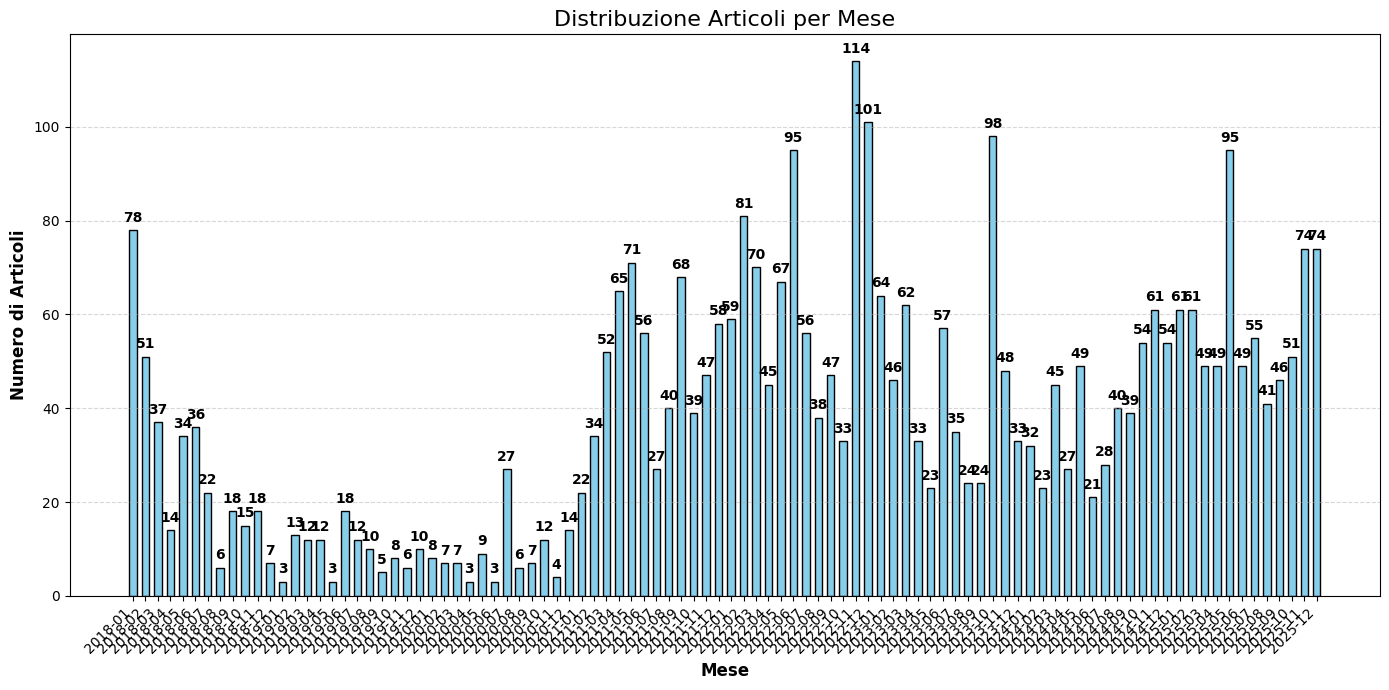

In [12]:
# 1. Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

# 2. Recupero Dati (SEMPLIFICATO)
# Non serve più l'aggregazione complessa. 
# Chiediamo a Mongo solo il campo 'pub_date' di tutti i documenti.
projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato! Assicurati di aver popolato il DB con il nuovo script.")
else:
    # 3. Preparazione DataFrame
    df = pd.DataFrame(data)
    
    # Verifica che la colonna 'pub_date' esista (per sicurezza)
    if 'pub_date' not in df.columns:
        print("ERRORE: Il campo 'pub_date' non è stato trovato nei documenti.")
        print("Esempio di documento nel DB:", collection.find_one())
    else:
        # Conversione data
        df['data'] = pd.to_datetime(df['pub_date'], errors='coerce')
        
        # Rimuove eventuali date non valide (NaT)
        df = df.dropna(subset=['data'])

        # Raggruppa per mese
        df['mese_anno'] = df['data'].dt.to_period('M')
        conteggio_mensile = df['mese_anno'].value_counts().sort_index()

        # Preparazione dati per il grafico
        mesi = conteggio_mensile.index.strftime('%Y-%m') 
        conteggi = conteggio_mensile.values

        # 4. Generazione Grafico (Il tuo codice di plotting era già ottimo!)
        plt.figure(figsize=(14, 7)) 
        
        plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

        plt.xlabel('Mese', fontsize=12, fontweight='bold')
        plt.ylabel('Numero di Articoli', fontsize=12, fontweight='bold')
        plt.title('Distribuzione Articoli per Mese', fontsize=16)
        
        # Formattazione asse X
        plt.xticks(
            rotation=45, 
            ha='right', 
            fontsize=10 
        )
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Etichette sopra le barre
        for i, v in enumerate(conteggi):
            plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\3403604660.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


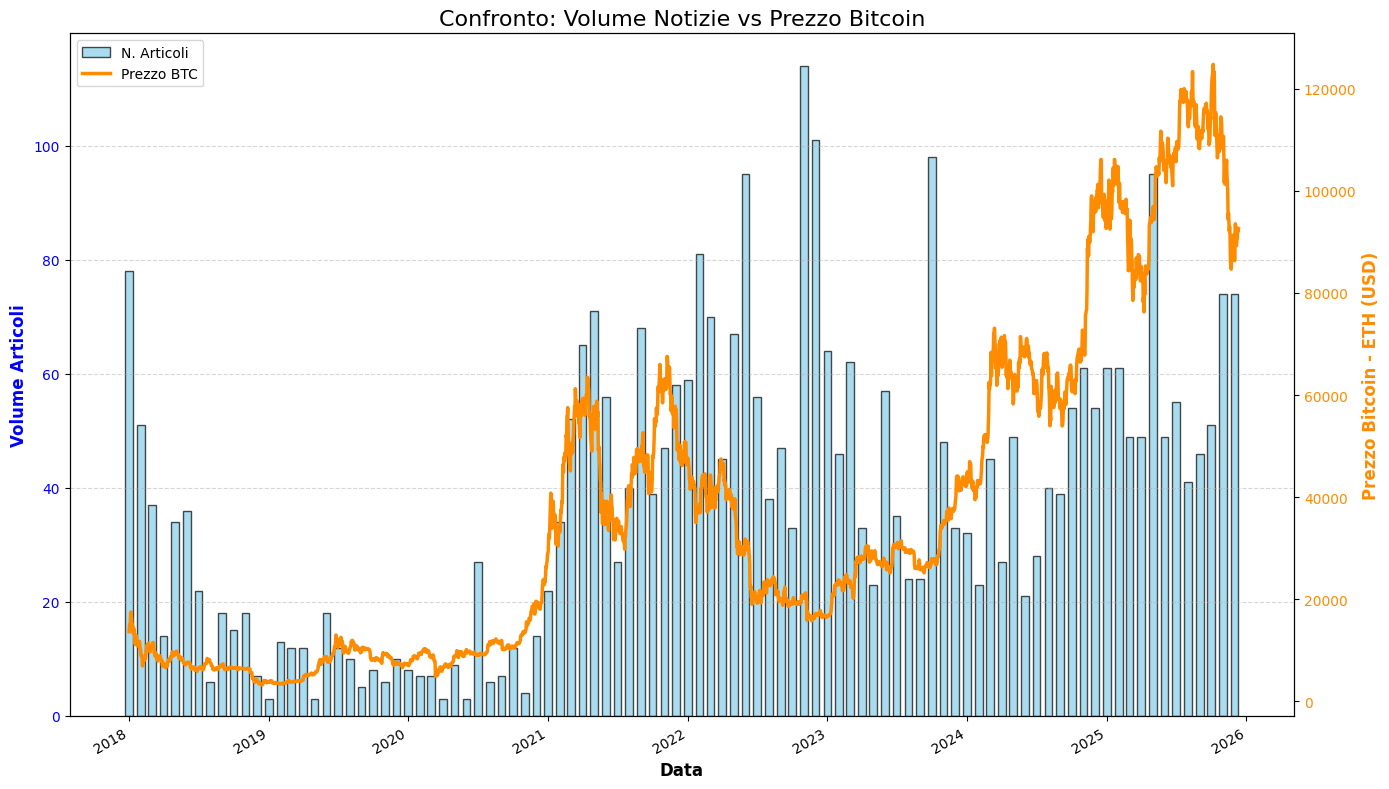

In [15]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzo, color=color_line, linewidth=2.5, label='Prezzo BTC')


            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\2178150349.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


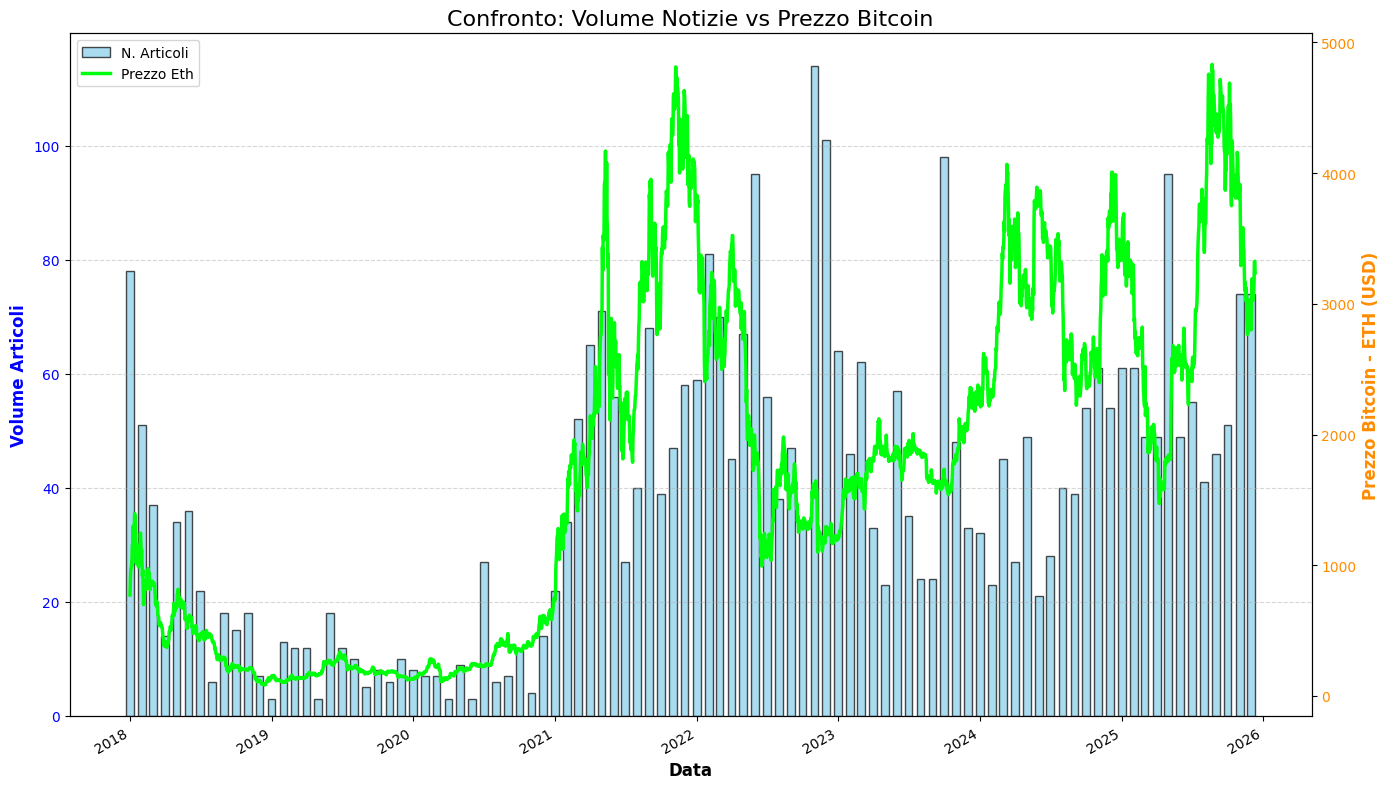

In [16]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzoeth, color=color_line2, linewidth=2.5, label='Prezzo Eth')

            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\2741525916.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


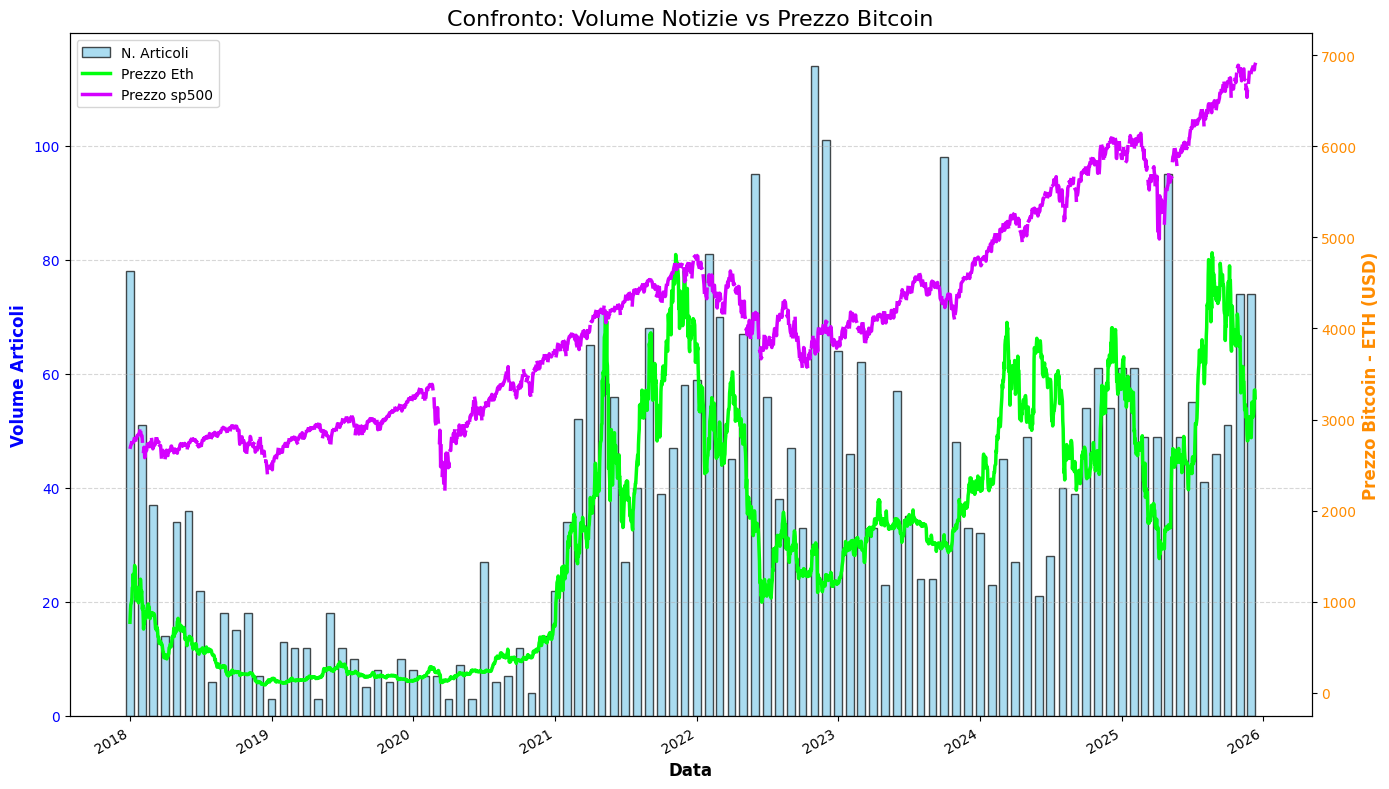

In [17]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzoeth, color=color_line2, linewidth=2.5, label='Prezzo Eth')
            ax2.plot(df_btc_filtered.index, prezzosp, color=color_line3, linewidth=2.5, label='Prezzo sp500')

            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()